### Sentiment Analysis 

In [47]:
import pandas as pd
import nltk
import re
import numpy as np
stop_words = nltk.corpus.stopwords.words('english')
import textblob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_document)

### Import Data

In [61]:
df_comment = pd.read_csv("/home/spuccio/God-of-Words/preprocessed_comment.csv",sep="\t",header=0)
df_comment.dropna(inplace=True)
df_comment.drop_duplicates(['no_stop_words'],keep='first', inplace=True)
df_comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37491 entries, 0 to 39063
Data columns (total 10 columns):
comment          37491 non-null object
Gioco            37491 non-null object
URL              37491 non-null object
Video            37491 non-null object
no_contracted    37491 non-null object
no_accent        37491 non-null object
no_duplicate     37491 non-null object
no_special       37491 non-null object
language         37491 non-null object
no_stop_words    37491 non-null object
dtypes: object(10)
memory usage: 3.1+ MB


In [62]:
norm_corpus = normalize_corpus(list(df_comment['no_stop_words']))
len(norm_corpus)

37491

In [63]:
#norm_corpus = list(df_comment['no_stop_words'])

### Polarity with textblob

In [64]:
sentiment_polarity_textblob = [textblob.TextBlob(comment).sentiment.polarity for comment in norm_corpus]
predicted_sentiments_textblob = ['positive' if score >= 0.1 else 'negative' for score in sentiment_polarity_textblob]

In [65]:
len(predicted_sentiments_textblob)

37491

### Polarity with Vader

In [8]:
analyzer = SentimentIntensityAnalyzer()
vader_results = [analyzer.polarity_scores(comment) for comment in norm_corpus]
sentiment_polarity_vader = list(pd.DataFrame(vader_results)['compound'])
predicted_sentiments_textblob = ['positive' if score >= 0.1 else 'negative' for score in sentiment_polarity_vader]

### Create Df witn polarity for textblob

In [9]:
out = pd.DataFrame(norm_corpus,[sentiment_polarity_textblob]).reset_index()
out.columns = ['sentiment_polarity_textblob','comment']

### Create Df witn polarity for vader

In [10]:
out2 = pd.DataFrame(norm_corpus,[sentiment_polarity_vader]).reset_index()
out2.columns = ['sentiment_polarity_vader','comment']

In [11]:
df_merge = pd.merge(out,out2,on="comment")

<AxesSubplot:ylabel='Frequency'>

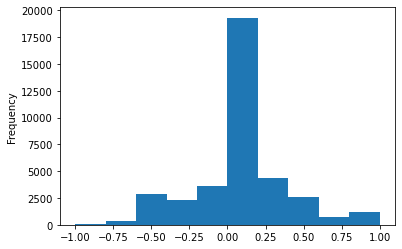

In [12]:
df_merge['sentiment_polarity_textblob'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

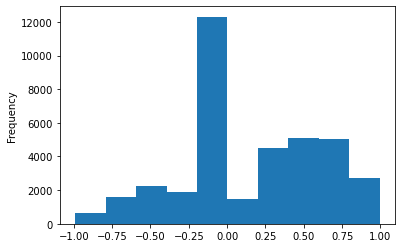

In [13]:
df_merge['sentiment_polarity_vader'].plot.hist()

In [71]:
df_merge.to_csv("/home/spuccio/God-of-Words/df_merge.csv",sep="\t",header=True,index=False)

In [69]:
df_merge.loc[(df_merge['sentiment_polarity_textblob'] == 0) & (df_merge['sentiment_polarity_vader'] >= 0.75)]

,sentiment_polarity_textblob,comment,sentiment_polarity_vader
1053,0.0,know struck beauty trailer beauty song probabl...,0.7650
3350,0.0,someone knows name th song xd traducion alguie...,0.8225
3367,0.0,cutest laughing pineapple tho,0.7906
3522,0.0,hope make game free play pc soon,0.8225
3665,0.0,pls allow fall guys android play store existin...,0.8020
...,...,...,...
35303,0.0,wish friends play video games,0.8020
36435,0.0,hear miles saying tryna catch hands know yet b...,0.8402
36772,0.0,hope spiderman sequal get symbiote suit even v...,0.7506
36864,0.0,woo yeah baby waiting woo,0.8126


### Set threshold for Textblob

In [15]:
threshold = 0.5

In [16]:
filtered_pos_neg_textblob = df_merge.loc[(df_merge['sentiment_polarity_textblob'] > threshold) | (df_merge['sentiment_polarity_textblob'] < threshold*(-1))]

In [17]:
filtered_pos_neg_textblob['final_sentiment'] = np.where(filtered_pos_neg_textblob['sentiment_polarity_textblob'] > 0,"positive",np.where(filtered_pos_neg_textblob['sentiment_polarity_textblob']<0,"negative",1)) 

/home/spuccio/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

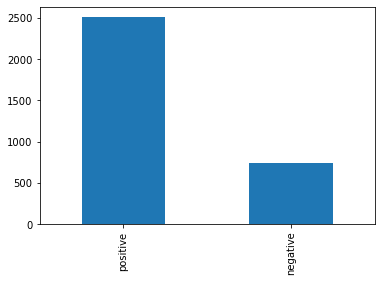

In [24]:
filtered_pos_neg_textblob.final_sentiment.value_counts().plot.bar()

### Set threshold for Vader

In [18]:
threshold = 0.5
filtered_pos_neg_vader = df_merge.loc[(df_merge['sentiment_polarity_vader'] > threshold) | (df_merge['sentiment_polarity_vader'] < threshold*(-1))]

In [20]:
filtered_pos_neg_vader['final_sentiment'] = np.where(filtered_pos_neg_vader['sentiment_polarity_vader'] > 0,"positive",np.where(filtered_pos_neg_vader['sentiment_polarity_vader']<0,"negative",1)) 

/home/spuccio/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

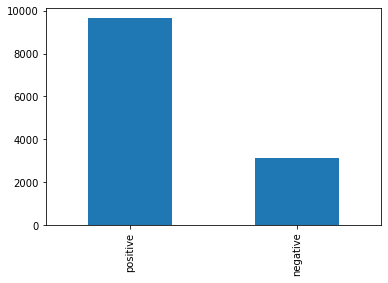

In [23]:
filtered_pos_neg_vader.final_sentiment.value_counts().plot.bar()

### Logistic Regression with TextBlob

In [25]:
filtered_pos_neg_textblob

,sentiment_polarity_textblob,comment,sentiment_polarity_vader,final_sentiment
5,0.70,brazilian silvers actually good ones,0.4404,positive
6,1.00,still got intro got best intro ever heard,0.6369,positive
11,0.56,really enjoy videos bro keep good grind harry ...,0.9516,positive
16,0.60,good incredible hahahaha,0.4404,positive
26,0.70,actually really good hope continue content,0.7485,positive
...,...,...,...,...
37430,0.90,dude pro tip play performance mode games looks...,0.3400,positive
37447,-0.70,noticed probably bad guy time,-0.5423,negative
37453,0.80,griffin puatu great job voicing ganke presh ed...,0.6249,positive
37459,0.60,peter kind looks like scott woz,0.7096,positive


In [26]:
X_train,X_test,y_train,y_test = train_test_split(filtered_pos_neg_textblob['comment'].values,filtered_pos_neg_textblob['final_sentiment'].values,test_size =0.3,random_state=345)

In [27]:
vect = CountVectorizer(min_df = 5, max_features = None, lowercase=False)

In [28]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [29]:
tf_train.shape

(2270, 545)

In [30]:
#print(vect.vocabulary_)

In [31]:
lr = LogisticRegression()
lr.fit(tf_train, y_train)

LogisticRegression()

In [32]:
lr.score(tf_test, y_test)

0.9640657084188912

In [33]:
lr.score(tf_train, y_train)

0.9876651982378855

In [34]:
expected = y_test
predicted = lr.predict(tf_test)

In [35]:
cf = metrics.confusion_matrix(expected,predicted,labels=['positive','negative']) 

In [36]:
print(cf)

[[758   3]
 [ 32 181]]


In [37]:
print(metrics.classification_report(expected,predicted))

              precision    recall  f1-score   support

    negative       0.98      0.85      0.91       213
    positive       0.96      1.00      0.98       761

    accuracy                           0.96       974
   macro avg       0.97      0.92      0.94       974
weighted avg       0.96      0.96      0.96       974



### Logistic Regression with Vader

In [38]:
filtered_pos_neg_vader

,sentiment_polarity_textblob,comment,sentiment_polarity_vader,final_sentiment
0,0.225000,actually good unbelievable god like quote,0.8074,positive
1,0.113636,positive energy one reason well going use tech...,0.7783,positive
3,0.392857,everton fan right swear quoted line fields anf...,0.7430,positive
6,1.000000,still got intro got best intro ever heard,0.6369,positive
11,0.560000,really enjoy videos bro keep good grind harry ...,0.9516,positive
...,...,...,...,...
37476,0.800000,makes happy see happy,0.8126,positive
37477,0.212121,petes new face fit yuri lowenthals voice like ...,0.6124,positive
37480,-0.300000,wanting watch getting game xmas rest youtube dead,-0.6486,negative
37483,-0.331818,hate new face also copying tasm swing scenes,-0.5719,negative


In [39]:
X_train,X_test,y_train,y_test = train_test_split(filtered_pos_neg_vader['comment'].values,filtered_pos_neg_vader['final_sentiment'].values,test_size =0.3,random_state=345)

In [40]:
vect = CountVectorizer(min_df = 5, max_features = None, lowercase=False)

In [41]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [42]:
tf_train.shape

(8934, 2387)

In [43]:
lr = LogisticRegression()
lr.fit(tf_train, y_train)

LogisticRegression()

In [44]:
lr.score(tf_test, y_test)

0.9639686684073107

In [45]:
lr.score(tf_train, y_train)

0.9912693082605776

In [46]:
expected = y_test
predicted = lr.predict(tf_test)

In [48]:
cf = metrics.confusion_matrix(expected,predicted,labels=['positive','negative']) 

In [49]:
print(cf)

[[2835   33]
 [ 105  857]]


In [50]:
print(metrics.classification_report(expected,predicted))

              precision    recall  f1-score   support

    negative       0.96      0.89      0.93       962
    positive       0.96      0.99      0.98      2868

    accuracy                           0.96      3830
   macro avg       0.96      0.94      0.95      3830
weighted avg       0.96      0.96      0.96      3830



In [ ]:
 precision    recall  f1-score   support

    negative       0.98      0.85      0.91       213
    positive       0.96      1.00      0.98       761

    accuracy                           0.96       974
   macro avg       0.97      0.92      0.94       974
weighted avg       0.96      0.96      0.96       974


In [92]:
norm_corpus

array(['actually good unbelievable god like quote',
       'positive energy one reason well going use technique next wl',
       'harry weekend league every game go penalties winning scores goal seeming penalty king get',
       ..., 'jack really loud game', 'energy converter generator',
       'yeh miles made black suit'], dtype='<U1953')

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1, 3), min_df=2)
tfidf_matrix = tf.fit_transform(norm_corpus)
tfidf_matrix.shape

(37491, 44436)

In [94]:
tfidf_matrix.shape

(37491, 44436)

In [149]:
def predict_sentiment(a, train=predicted, model=lr):
  vect_text = vect.transform([a])
  pred = model.predict(vect_text)

  if(pred=='negative'):
    sentiment = 'Negative'
  elif(pred=='positive'):
    sentiment = 'Positive'

  return sentiment

In [150]:
text = 'bison look awesome'.lower()
predict_sentiment(text)

'Positive'

In [77]:
filtered_pos_neg_textblob['comment'].values

array(['brazilian silvers actually good ones',
       'still got intro got best intro ever heard',
       'really enjoy videos bro keep good grind harry mayday shoutout good shoutout kurt definitely favorite fifa youtubers favorite fifa youtuber',
       ...,
       'griffin puatu great job voicing ganke presh edit know also voiced louis deer beastars dubbed version',
       'peter kind looks like scott woz', 'makes happy see happy'],
      dtype=object)

In [79]:
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords

In [82]:
stop = stopwords.words('english')
stop.extend(['good', 'many', 'love', 'excellent', 'would'])

bigram = Phrases(filtered_pos_neg_textblob['comment'], min_count=5, threshold=0.2, common_terms=stop)
print(bigram[filtered_pos_neg_textblob['comment'][5]])

['b', 'r', 'a', 'z', 'i', 'l', 'i', 'a', 'n', ' ', 's', 'i', 'l', 'v', 'e', 'r', 's', ' ', 'a', 'c', 't', 'u', 'a', 'l', 'l', 'y', ' ', 'g', 'o', 'o', 'd', ' ', 'o', 'n', 'e', 's']


In [84]:
sentence_stream = [doc.split(" ") for doc in filtered_pos_neg_textblob['comment']]

In [85]:
sentence_stream

[['brazilian', 'silvers', 'actually', 'good', 'ones'],
 ['still', 'got', 'intro', 'got', 'best', 'intro', 'ever', 'heard'],
 ['really',
  'enjoy',
  'videos',
  'bro',
  'keep',
  'good',
  'grind',
  'harry',
  'mayday',
  'shoutout',
  'good',
  'shoutout',
  'kurt',
  'definitely',
  'favorite',
  'fifa',
  'youtubers',
  'favorite',
  'fifa',
  'youtuber'],
 ['good', 'incredible', 'hahahaha'],
 ['actually', 'really', 'good', 'hope', 'continue', 'content'],
 ['harry',
  'twitch',
  'streams',
  'best',
  'things',
  'ever',
  'btw',
  'good',
  'time',
  'vibr'],
 ['one', 'without', 'star', 'skilers', 'would', 'awesome', 'man'],
 ['timing', 'skills', 'insane'],
 ['played', 'exact', 'team', 'wl', 'ps', 'tho', 'even', 'subs', 'lol'],
 ['actually',
  'happy',
  'using',
  'villa',
  'badge',
  'hes',
  'hes',
  'hes',
  'every',
  'f',
  'king',
  'tyrone',
  'mings',
  'tyrone',
  'mings'],
 ['loving', 'energie', 'confidence', 'man'],
 ['good', 'elevator', 'music', 'background'],
 ['l

In [86]:
bigram = Phrases(sentence_stream, min_count=1, threshold=2)

In [87]:
bigram

In [90]:
print(bigram[filtered_pos_neg_textblob['comment']])

['brazilian silvers actually good ones', 'still got intro got best intro ever heard', 'really enjoy videos bro keep good grind harry mayday shoutout good shoutout kurt definitely favorite fifa youtubers favorite fifa youtuber', 'good incredible hahahaha', 'actually really good hope continue content', 'harry twitch streams best things ever btw good time vibr', 'one without star skilers would awesome man', 'timing skills insane', 'played exact team wl ps tho even subs lol', 'actually happy using villa badge hes hes hes every f king tyrone mings tyrone mings', 'loving energie confidence man', 'good elevator music background', 'league hybrid team budget mil great vid', 'great content mate would love see pull something great', 'great vid club fut champions would good see', 'reason harry one best fifa player bantering playing love', 'bought promes vid mil team best decision ever made', 'feel time year team good want would recommend try futglobal mencret online solution everyone', 'say guy ra

In [91]:
bigrams = [bigram[item] for item in text]
ngrams = [bigram[item] for item in bigrams]
print(ngrams[5])

NameError: name 'text' is not defined